In [1]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
from torchvision import datasets as Datasets
from torchvision import transforms

cifar10_train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


cifar10_test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#  loading training data
training_set = Datasets.CIFAR10(root='../../autoencoder', download=False, train=True, transform=cifar10_train_transforms)

#  loading validation data
validation_set = Datasets.CIFAR10(root='../../autoencoder', download=False, train=False, transform=cifar10_test_transforms)

# Dict for label to class
l2c = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

/home/ritish/prog/ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)

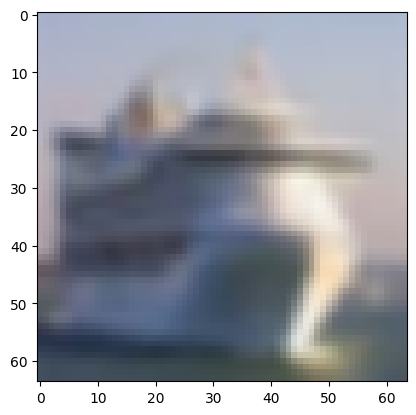

In [6]:
# Show image
img, label = next(iter(train_loader))
plt.imshow(img[0].permute(1, 2, 0)*.5+.5)

In [7]:
class VAE(nn.Module):
    def __init__(self, image_size, in_channels, out_channels, latent_size):
        super().__init__()
        self.image_size = image_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.latent_size = latent_size

        # Encoder
        self.encoder = nn.Sequential(
            self.conv_block(in_channels, 32, 4, 2, 1, act="leaky_relu"),
            self.conv_block(32, 64, 4, 2, 1, act="leaky_relu"),
            self.conv_block(64, 128, 4, 2, 1, act="leaky_relu"),
            self.conv_block(128, 256, 4, 2, 1, act="leaky_relu"),
            self.conv_block(256, 512, 3, 1, 1, act="leaky_relu"),
            nn.Flatten()
        )

        # Calculate the size of the feature volume
        self.feature_size = image_size // 2**4
        self.feature_volume = 512 * self.feature_size**2

        # Mean and variance predictor
        self.mean_predictor = nn.Linear(self.feature_volume, latent_size)
        self.logvar_predictor = nn.Linear(self.feature_volume, latent_size)

        # Project latent space to feature volume
        self.latent_projector = nn.Linear(latent_size, self.feature_volume)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, self.feature_size, self.feature_size)),
            self.convT_block(512, 256, 3, 1, 1),
            self.convT_block(256, 128, 4, 2, 1),
            self.convT_block(128, 64, 4, 2, 1),
            self.convT_block(64, 32, 4, 2, 1),
            self.convT_block(32, out_channels, 4, 2, 1, act='tanh', batch_norm=False)
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mean = self.mean_predictor(x)
        logvar = self.logvar_predictor(x)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        z = torch.randn_like(std) * std + mean

        # Decode
        z = self.latent_projector(z)
        z = self.decoder(z)

        return mean, logvar, z
    
    def recon_loss(self, recon, x):
        return F.mse_loss(recon, x, reduction='sum') / x.size(0)
    
    def kl_loss(self, mean, logvar):
        return -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

    def conv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, act='leaky_relu', leaky_slope=0.2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(leaky_slope, inplace=True) if act == 'leaky_relu' else nn.GELU()
        )

    def convT_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, act='leaky_relu', leaky_slope=0.2, batch_norm=True):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.LeakyReLU(leaky_slope, inplace=True) if act == 'leaky_relu' else nn.Tanh()
        )

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(64, 3, 3, 256).to(device)

In [9]:
# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=3e-4)

In [10]:
# Training loop
epochs = 5
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    tqdm_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

    for img, _ in tqdm_iterator:
        img = img.to(device)
        optimizer.zero_grad()
        mean, logvar, recon = vae(img)
        recon_loss = vae.recon_loss(recon, img)
        kl_loss = vae.kl_loss(mean, logvar)
        loss = recon_loss + kl_loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        tqdm_iterator.set_description(f'Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f} '
                                      f'(Recon Loss: {recon_loss.item():.4f}, '
                                      f'KL Loss: {kl_loss.item():.4f})')
    print(f'Epoch {epoch+1}/{epochs} Loss: {train_loss/len(train_loader)}')

Epoch 1/5 Loss: 458.7934 (Recon Loss: 455.0833, KL Loss: 3.7101): 100%|██████████| 391/391 [00:06<00:00, 60.66it/s]     


Epoch 1/5 Loss: 988.8904598460477


Epoch 2/5 Loss: 288.6946 (Recon Loss: 284.6591, KL Loss: 4.0355): 100%|██████████| 391/391 [00:06<00:00, 62.68it/s]


Epoch 2/5 Loss: 372.2603572445452


Epoch 3/5 Loss: 225.5057 (Recon Loss: 221.1404, KL Loss: 4.3653): 100%|██████████| 391/391 [00:06<00:00, 62.67it/s]


Epoch 3/5 Loss: 273.9697097427095


Epoch 4/5 Loss: 197.2833 (Recon Loss: 192.6301, KL Loss: 4.6532): 100%|██████████| 391/391 [00:06<00:00, 62.66it/s]


Epoch 4/5 Loss: 226.04787423604589


Epoch 5/5 Loss: 165.5074 (Recon Loss: 160.7402, KL Loss: 4.7672): 100%|██████████| 391/391 [00:06<00:00, 62.26it/s]

Epoch 5/5 Loss: 197.35606723795158


In [17]:
def show_reconstructions(model, loader):
    model.eval()
    img, _ = next(iter(loader))
    img = img.to(device)
    _, _, recon = model(img)
    img = img.cpu()
    recon = recon.detach().cpu()

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(5):
        axes[0, i].imshow(img[i].permute(1, 2, 0)*.5+.5)
        axes[1, i].imshow(recon[i].permute(1, 2, 0)*.5+.5)
        axes[0, i].axis('off')
        axes[1, i].axis('off')

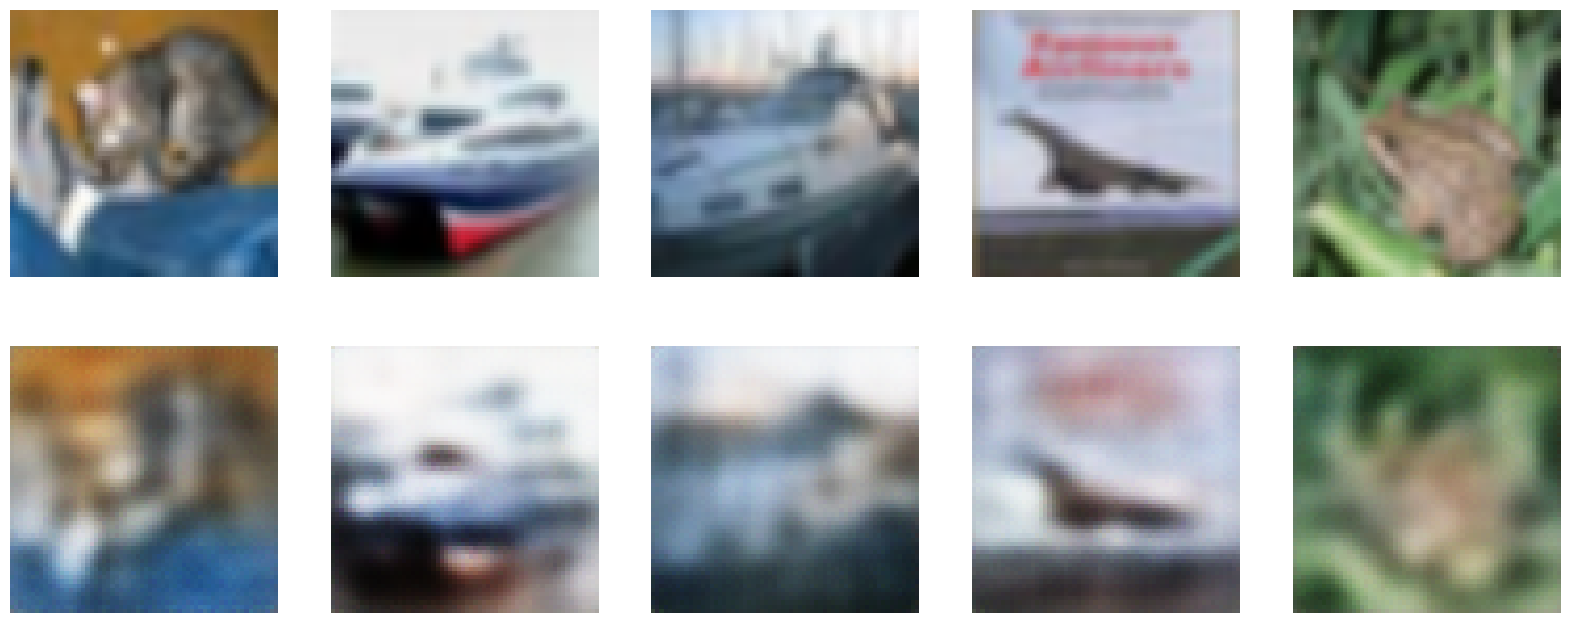

In [18]:
show_reconstructions(vae, val_loader)